
# Cervical Cytology Segmentation — KMeans + GMM (full covariance) from scratch

This notebook implements the segmentation pipeline for Dataset 2(c) (cervical cytology) **from scratch** using only **NumPy** and **Matplotlib** for image I/O and plotting — no scikit-learn / OpenCV / PIL.

What it does:
- Reads images from `train/` and `test/` folders under `DATA_ROOT`.
- Extracts overlapping 7×7 patches with stride 1 and computes 2-D features per patch: `[mean, std]`.
- Runs **K-Means** (K=3) on training patch features.
- Initializes a **3-component GMM** with **full 2×2 covariances** from K-Means and performs **exactly 1 EM iteration**.
- Assigns patches to clusters using GMM posteriors and produces segmented images (pixel-wise via majority voting over overlapping patches).
- If ground-truth masks are available in `test/` (same filename with `_mask` suffix or in a parallel `masks/` folder), computes confusion matrix and precision/recall/F1 per class; otherwise it skips numeric evaluation and only shows visualizations.
- Plots: training scatter (mean vs std) colored by KMeans clusters, log-likelihood before/after 1 EM iteration, and example segmented test images.

**Edit `DATA_ROOT` in the configuration cell to point to your dataset root.**


In [1]:

# Imports (only numpy & matplotlib used)
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter, defaultdict
np.set_printoptions(precision=4, suppress=True)


In [2]:

# Configuration - set DATA_ROOT to the folder that contains 'train' and 'test' subfolders
# Example: DATA_ROOT = './Dataset2c' or an absolute path
DATA_ROOT = '../Dataset/Group04-cervical_cytology_images/group04/'   # <-- change this to your dataset root
TRAIN_DIR = os.path.join(DATA_ROOT, 'Train')
TEST_DIR  = os.path.join(DATA_ROOT, 'Test')

PATCH_SIZE = 7
STRIDE = 1
K = 3             # number of clusters/components
EPS = 1e-6        # small regularizer for covariances
MAX_KMEANS_ITERS = 200
RANDOM_STATE = 0  # reproducibility


In [3]:

# Image utilities
def read_rgb(path):
    img = mpimg.imread(path)
    if img.dtype == np.float32 or img.dtype == np.float64:
        if img.max() <= 1.01:
            img = (img * 255.0).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    if img.ndim == 2:
        img = np.stack([img]*3, axis=2)
    if img.shape[2] == 4:
        img = img[:,:,:3]
    return img

def rgb2gray(img):
    return (0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]).astype(np.float64)


In [4]:

# Extract overlapping 7x7 patches (stride=1) and compute [mean,std] for each patch
def extract_patches_mean_std(gray_img, patch_size=PATCH_SIZE, stride=STRIDE):
    H, W = gray_img.shape
    feats = []
    coords = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = gray_img[y:y+patch_size, x:x+patch_size]
            mu = float(np.mean(patch))
            sigma = float(np.std(patch))
            feats.append([mu, sigma])
            coords.append((y,x))
    return np.array(feats), coords  # feats: P x 2, coords: list of length P


In [5]:

# Prepare dataset: read train/test images and extract patch features per image
def list_image_files(folder):
    exts = ('.jpg','.jpeg','.png','.tif','.tiff')
    return sorted([f for f in os.listdir(folder) if f.lower().endswith(exts)])

def build_split_features(split_dir):
    # Returns dict: filename -> {'path', 'feats' (P x 2), 'coords', 'shape'}
    items = {}
    files = list_image_files(split_dir)
    for fname in files:
        path = os.path.join(split_dir, fname)
        rgb = read_rgb(path)
        gray = rgb2gray(rgb)
        feats, coords = extract_patches_mean_std(gray)
        items[fname] = {'path': path, 'feats': feats, 'coords': coords, 'shape': gray.shape}
    return items

# Build training features by stacking patches from all training images
print('Building training features from', TRAIN_DIR)
train_items = build_split_features(TRAIN_DIR)
print('Found', len(train_items), 'training images.')

print('Building test features from', TEST_DIR)
test_items = build_split_features(TEST_DIR)
print('Found', len(test_items), 'test images.')

# Stack all training patches into one array
train_patches_list = [entry['feats'] for entry in train_items.values()]
if len(train_patches_list) == 0:
    raise RuntimeError('No training images found or no patches extracted. Check DATA_ROOT and TRAIN_DIR.')
train_patches_all = np.vstack(train_patches_list)
print('Total training patches:', train_patches_all.shape)


Building training features from ../Dataset/Group04-cervical_cytology_images/group04/Train
Found 60 training images.
Building test features from ../Dataset/Group04-cervical_cytology_images/group04/Test
Found 3 test images.
Total training patches: (15362160, 2)


In [6]:

# KMeans from scratch (Lloyd's algorithm)
class KMeansScratch:
    def __init__(self, n_clusters=3, max_iter=200, tol=1e-4, random_state=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X):
        rng = np.random.RandomState(self.random_state)
        n, d = X.shape
        if n < self.n_clusters:
            raise ValueError('Not enough points to cluster: n={}, k={}'.format(n, self.n_clusters))
        init_idx = rng.choice(n, self.n_clusters, replace=False)
        centers = X[init_idx].astype(float)
        for it in range(self.max_iter):
            # assign
            dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            labels = np.argmin(dists, axis=1)
            # update
            new_centers = np.zeros_like(centers)
            for j in range(self.n_clusters):
                pts = X[labels == j]
                if len(pts) == 0:
                    new_centers[j] = X[rng.randint(n)]
                else:
                    new_centers[j] = pts.mean(axis=0)
            shift = np.linalg.norm(new_centers - centers)
            centers = new_centers
            if shift < self.tol:
                break
        self.cluster_centers_ = centers
        self.labels_ = labels
        return self

    def predict(self, X):
        dists = np.linalg.norm(X[:, None, :] - self.cluster_centers_[None, :, :], axis=2)
        return np.argmin(dists, axis=1)


In [7]:

# GMM with full covariance matrices (from scratch). We'll run exactly 1 EM iteration.
def log_mvnpdf_full(x, mean, cov):
    x = np.atleast_2d(x)
    d = mean.shape[0]
    cov_reg = cov + EPS * np.eye(d)
    sign, logdet = np.linalg.slogdet(cov_reg)
    if sign <= 0:
        cov_reg = cov_reg + (EPS*10) * np.eye(d)
        sign, logdet = np.linalg.slogdet(cov_reg)
    inv = np.linalg.inv(cov_reg)
    xc = x - mean
    exponent = -0.5 * np.sum(xc.dot(inv) * xc, axis=1)
    const = -0.5 * (d * np.log(2 * np.pi) + logdet)
    return const + exponent  # (n,)

class GMMFull:
    def __init__(self, n_components=3, random_state=0, reg_covar=EPS):
        self.n_components = n_components
        self.random_state = random_state
        self.reg_covar = reg_covar
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None

    def init_from_kmeans(self, X, kmeans):
        n, d = X.shape
        k = self.n_components
        centers = kmeans.cluster_centers_.copy()
        labels = kmeans.labels_
        weights = np.zeros(k)
        covs = np.zeros((k, d, d))
        for j in range(k):
            pts = X[labels == j]
            weights[j] = max(1e-8, pts.shape[0]) / float(n)
            if pts.shape[0] < 2:
                covs[j] = np.cov(X, rowvar=False) + self.reg_covar * np.eye(d)
            else:
                covs[j] = np.cov(pts, rowvar=False) + self.reg_covar * np.eye(d)
        weights = weights / weights.sum()
        self.weights_ = weights
        self.means_ = centers
        self.covariances_ = covs

    def e_step(self, X):
        n, d = X.shape
        k = self.n_components
        log_resp = np.zeros((n, k))
        for j in range(k):
            log_resp[:, j] = np.log(self.weights_[j] + 1e-12) + log_mvnpdf_full(X, self.means_[j], self.covariances_[j])
        max_lr = np.max(log_resp, axis=1, keepdims=True)
        rr = np.exp(log_resp - max_lr)
        rr_sum = rr.sum(axis=1, keepdims=True)
        resp = rr / (rr_sum + 1e-12)
        log_likelihood = np.sum(max_lr + np.log(rr_sum + 1e-12))
        return resp, log_likelihood

    def m_step(self, X, resp):
        n, d = X.shape
        nk = resp.sum(axis=0) + 1e-12
        weights = nk / n
        means = (resp.T @ X) / nk[:, None]
        covs = np.zeros((self.n_components, d, d))
        for j in range(self.n_components):
            diff = X - means[j]
            cov = (resp[:, j][:, None] * diff).T @ diff / nk[j]
            cov += self.reg_covar * np.eye(d)
            covs[j] = cov
        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covs

    def fit_one_iter(self, X):
        _, ll_before = self.e_step(X)
        resp, _ = self.e_step(X)
        self.m_step(X, resp)
        _, ll_after = self.e_step(X)
        return ll_before, ll_after, resp


In [8]:

# Map clusters to ground-truth labels if masks available, else produce visual-only output
def try_load_mask_for_image(img_path):
    # Heuristics: look for same filename with '_mask' suffix, or in a subfolder 'masks' next to the test dir
    base, ext = os.path.splitext(os.path.basename(img_path))
    candid1 = os.path.join(os.path.dirname(img_path), base + '_mask' + ext)
    candid2 = os.path.join(os.path.dirname(img_path), 'masks', base + ext)
    if os.path.exists(candid1):
        m = mpimg.imread(candid1)
        if m.ndim==3:
            m = m[:,:,0]
        return m.astype(int)
    if os.path.exists(candid2):
        m = mpimg.imread(candid2)
        if m.ndim==3:
            m = m[:,:,0]
        return m.astype(int)
    return None

def map_clusters_to_labels_using_training(kmeans, train_items):
    # For each training patch, get its kmeans cluster and (if masks in training available) its true label.
    # We attempt to find a mapping only if training masks exist; otherwise mapping remains identity 0..K-1
    # Search for masks in train dir per image; if none found, return identity mapping
    cluster_to_label = {j: j for j in range(K)}
    # Try to build mapping using any training masks found
    # For each training image, try to load mask and use patch coords to get per-patch true labels
    counts = {j: Counter() for j in range(K)}
    any_masks = False
    for fname, entry in train_items.items():
        mask = try_load_mask_for_image(entry['path'])
        if mask is None:
            continue
        any_masks = True
        feats = entry['feats']; coords = entry['coords']
        # for each patch, take mask value at patch center (or majority inside patch)
        for pidx, (y,x) in enumerate(coords):
            # center
            cy, cx = y + PATCH_SIZE//2, x + PATCH_SIZE//2
            lab = int(mask[cy, cx])
            patch = entry['feats'][pidx].reshape(1, -1)
            cl = int(kmeans.predict(patch)[0])
            counts[cl][lab] += 1
    if not any_masks:
        return cluster_to_label, False
    # majority mapping
    for cl in range(K):
        if len(counts[cl]) == 0:
            cluster_to_label[cl] = -1
        else:
            cluster_to_label[cl] = counts[cl].most_common(1)[0][0]
    return cluster_to_label, True


In [9]:

# Run KMeans, init GMM, run one EM iteration, segment test images, and evaluate if masks available
print('Running KMeans on training patches...')
kmeans = KMeansScratch(n_clusters=K, max_iter=MAX_KMEANS_ITERS, tol=1e-4, random_state=RANDOM_STATE)
kmeans.fit(train_patches_all)
km_labels = kmeans.labels_

print('Initializing GMM from KMeans and performing 1 EM iteration...')
gmm = GMMFull(n_components=K, random_state=RANDOM_STATE, reg_covar=EPS)
gmm.init_from_kmeans(train_patches_all, kmeans)
ll_before, ll_after, resp = gmm.fit_one_iter(train_patches_all)
print('Log-likelihood before EM:', ll_before)
print('Log-likelihood after 1 EM iteration:', ll_after)

# Try to map clusters to semantic labels using training masks if available
cluster_to_label_map, has_train_masks = map_clusters_to_labels_using_training(kmeans, train_items)
print('Cluster->label map (using training masks if present):', cluster_to_label_map, '  has_train_masks=', has_train_masks)

# Now segment test images and optionally evaluate if masks present
y_true = []
y_pred = []
have_test_masks = False
per_image_results = []

for fname, entry in test_items.items():
    feats = entry['feats']; coords = entry['coords']; H,W = entry['shape']
    # compute posterior responsibilities per patch under GMM
    n = feats.shape[0]
    log_resp = np.zeros((n, K))
    for j in range(K):
        log_resp[:, j] = np.log(gmm.weights_[j] + 1e-12) + log_mvnpdf_full(feats, gmm.means_[j], gmm.covariances_[j])
    max_lr = np.max(log_resp, axis=1, keepdims=True)
    rr = np.exp(log_resp - max_lr)
    resp = rr / (rr.sum(axis=1, keepdims=True) + 1e-12)
    comps = np.argmax(resp, axis=1)
    # map components to labels (if mapping is available)
    mapped = np.array([cluster_to_label_map.get(int(c), -1) for c in comps])
    # create pixel-level segmentation via majority voting of overlapping patches
    votes = np.zeros((H, W, K), dtype=int)
    for pidx, (y,x) in enumerate(coords):
        lab = mapped[pidx]
        if lab < 0 or lab >= K:
            # if no mapping, use component index as label
            lab = int(comps[pidx])
        votes[y:y+PATCH_SIZE, x:x+PATCH_SIZE, lab] += 1
    seg = np.argmax(votes, axis=2)  # H x W labels (0..K-1)
    # try to load test mask for evaluation
    mask = try_load_mask_for_image(entry['path'])
    if mask is not None:
        have_test_masks = True
        # compute per-image predicted class via majority of pixels (for overall image-level eval if desired)
        # but for segmentation metrics we'll compare per-pixel
        # Align mask values to 0..K-1 if necessary (assume mask already encoded as 0..K-1)
        # Flatten and compute confusion contributions
        true_flat = mask.ravel().astype(int)
        pred_flat = seg.ravel().astype(int)
        per_image_results.append({'fname': fname, 'true_flat': true_flat, 'pred_flat': pred_flat, 'shape': seg.shape})
    else:
        per_image_results.append({'fname': fname, 'seg': seg, 'shape': seg.shape})

print('Segmentation completed for', len(test_items), 'test images. have_test_masks=', have_test_masks)


Running KMeans on training patches...
Initializing GMM from KMeans and performing 1 EM iteration...
Log-likelihood before EM: -88311420.25250591
Log-likelihood after 1 EM iteration: -80007462.63428135
Cluster->label map (using training masks if present): {0: 0, 1: 1, 2: 2}   has_train_masks= False
Segmentation completed for 3 test images. have_test_masks= False


In [10]:

# If we have per-image true/pred flattened arrays, compute confusion matrix and metrics aggregated across test images
if any('true_flat' in r for r in per_image_results):
    # aggregate across images
    all_true = np.concatenate([r['true_flat'] for r in per_image_results if 'true_flat' in r])
    all_pred = np.concatenate([r['pred_flat'] for r in per_image_results if 'pred_flat' in r])
    # determine number of classes from true labels and predicted labels
    classes_true = np.unique(all_true)
    classes_pred = np.unique(all_pred)
    C = int(max(all_true.max(), all_pred.max()) + 1)
    cm = np.zeros((C, C), dtype=int)
    for t,p in zip(all_true, all_pred):
        cm[int(t), int(p)] += 1
    tp = np.diag(cm).astype(float)
    predicted = cm.sum(axis=0)
    actual = cm.sum(axis=1)
    precision = np.where(predicted>0, tp/predicted, 0.0)
    recall = np.where(actual>0, tp/actual, 0.0)
    f1 = np.where((precision+recall)>0, 2*precision*recall/(precision+recall), 0.0)
    mean_precision = precision.mean()
    mean_recall = recall.mean()
    mean_f1 = f1.mean()
    accuracy = tp.sum() / cm.sum()
    print('\\nConfusion matrix (rows=true, cols=pred):\\n', cm)
    print('\\nPer-class precision:', precision)
    print('Per-class recall:', recall)
    print('Per-class F1:', f1)
    print('\\nMean precision:', mean_precision)
    print('Mean recall:', mean_recall)
    print('Mean F1:', mean_f1)
    print('Overall accuracy:', accuracy)
else:
    print('No ground-truth masks found in test set. Skipping numeric evaluation.')


No ground-truth masks found in test set. Skipping numeric evaluation.


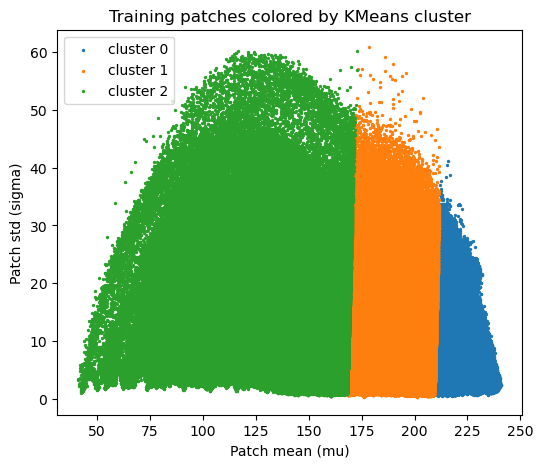

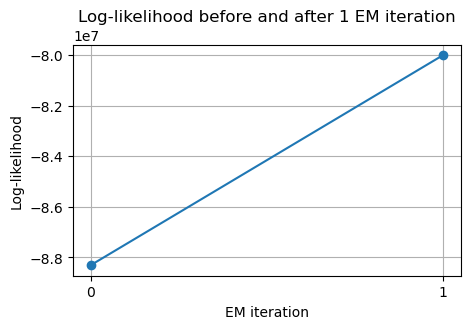

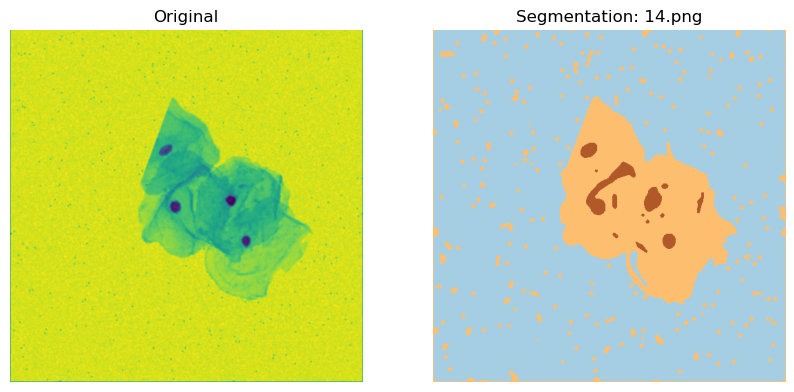

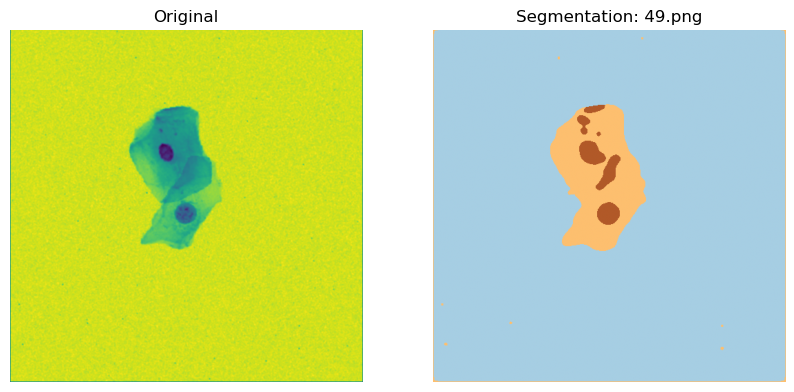

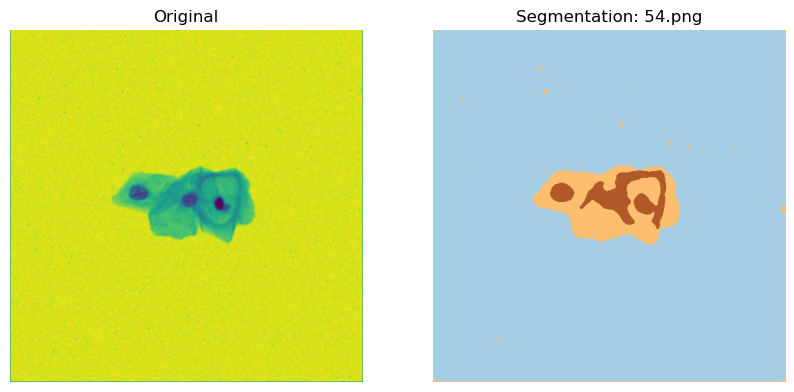

In [15]:

# Plots: training scatter by KMeans cluster, log-likelihood before/after, and show segmented images
plt.figure(figsize=(6,5))
labels = kmeans.labels_
for k in range(K):
    idxs = np.where(labels==k)[0]
    plt.scatter(train_patches_all[idxs,0], train_patches_all[idxs,1], s=2, label=f'cluster {k}')
plt.xlabel('Patch mean (mu)'); plt.ylabel('Patch std (sigma)')
plt.title('Training patches colored by KMeans cluster'); plt.legend(); plt.show()

plt.figure(figsize=(5,3))
plt.plot([0,1], [ll_before, ll_after], marker='o')
plt.xlabel('EM iteration'); plt.ylabel('Log-likelihood'); plt.title('Log-likelihood before and after 1 EM iteration')
plt.xticks([0,1]); plt.grid(True); plt.show()



In [18]:
# Nice color map for K clusters
def get_colormap(k):
    from matplotlib import cm
    cmap = cm.get_cmap('tab10') if k <= 10 else cm.get_cmap('nipy_spectral')
    return [cmap(i) for i in range(k)]

# Plot segmentation results
def plot_segmentations(per_image_results, num_to_show=5):
    cmap = get_colormap(K)
    shown = 0
    for result in per_image_results:
        fname = result['fname']
        H, W = result['shape']
        seg = result.get('seg', result.get('pred_flat', None))
        if seg is None:
            continue
        if seg.ndim == 1:
            seg = seg.reshape(H, W)

        fig, axs = plt.subplots(1, 3 if 'true_flat' in result else 2, figsize=(12, 4))
        
        # Original image
        img_path = os.path.join(TEST_DIR, fname)
        rgb = read_rgb(img_path)
        axs[0].imshow(rgb)
        axs[0].set_title('Original')
        axs[0].axis('off')
        
        # Segmentation (prediction)
        axs[1].imshow(seg, cmap='tab10', vmin=0, vmax=K-1)
        axs[1].set_title('Predicted Segmentation')
        axs[1].axis('off')
        
        # Ground-truth mask (if available)
        if 'true_flat' in result:
            true_mask = result['true_flat'].reshape(H, W)
            axs[2].imshow(true_mask, cmap='tab10', vmin=0, vmax=K-1)
            axs[2].set_title('Ground Truth Mask')
            axs[2].axis('off')
        
        plt.suptitle(f'Segmentation Result: {fname}')
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= num_to_show:
            break




Visualizing KMeans vs GMM segmentations...


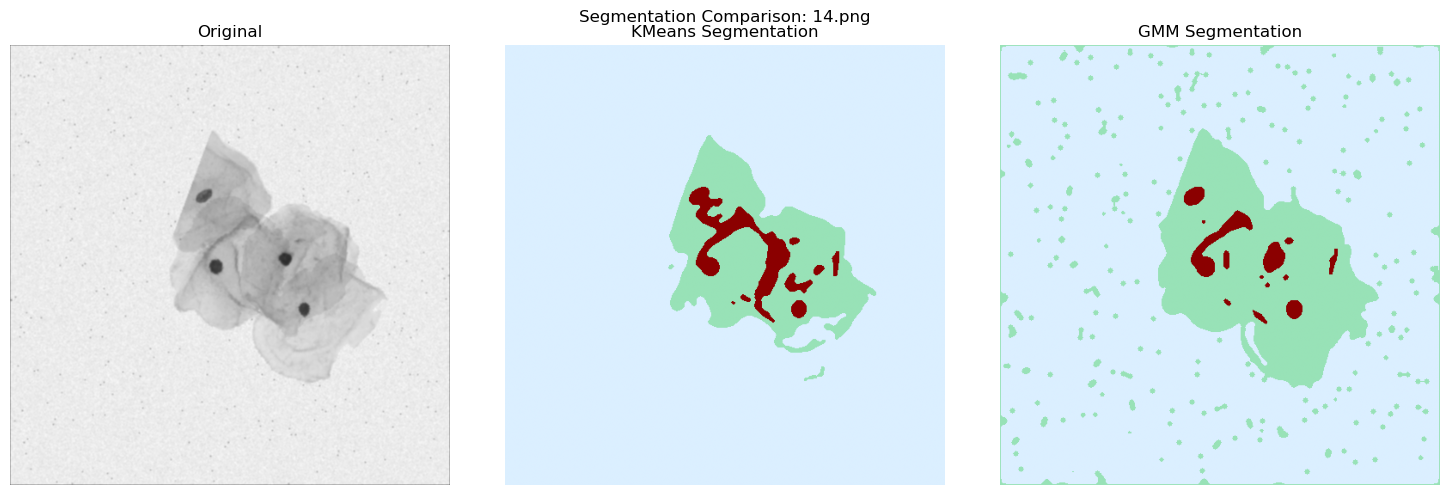

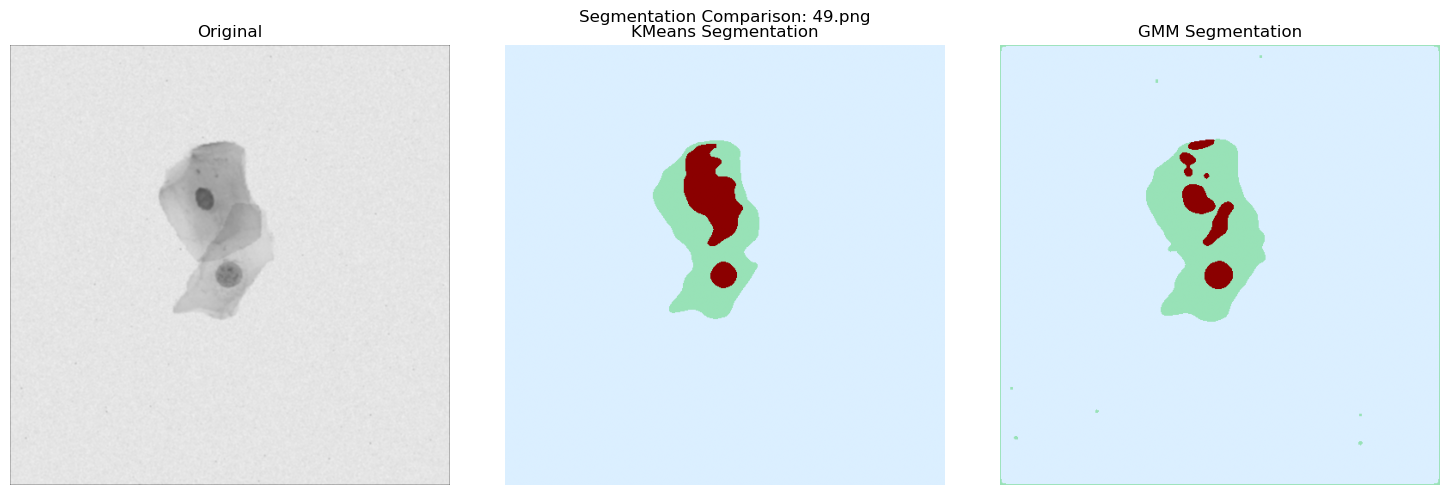

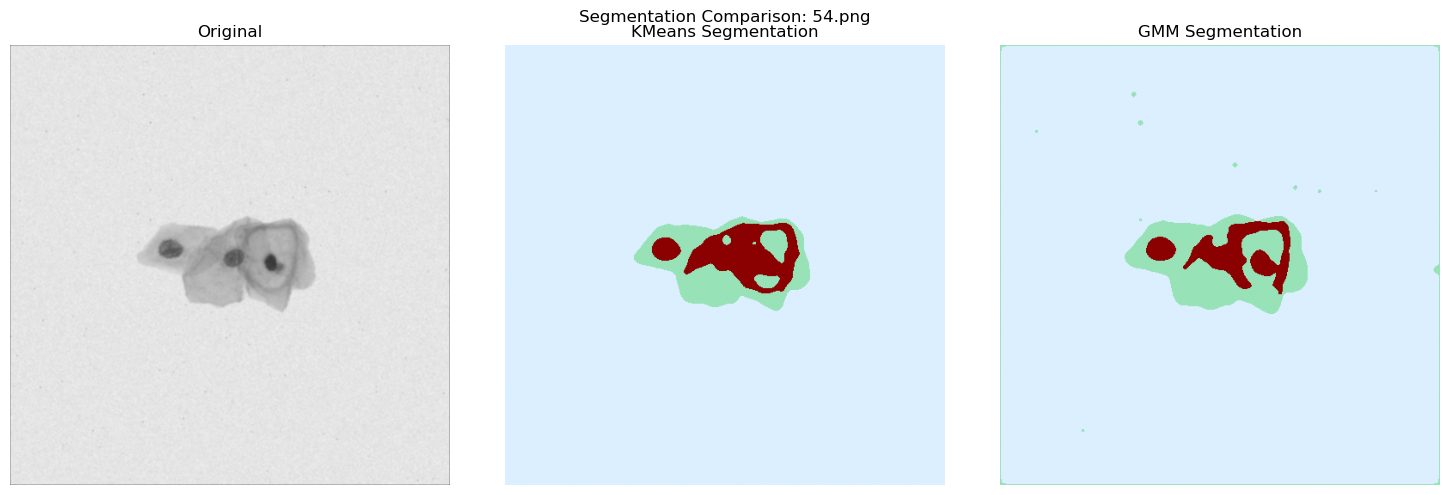

In [22]:
print('\nVisualizing KMeans vs GMM segmentations...')
visualize_segmentations_with_kmeans_gmm(test_items, per_image_results, kmeans, gmm, num_to_show=5)



Visualizing segmentations...


/tmp/ipykernel_19878/1364659178.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10') if k <= 10 else cm.get_cmap('nipy_spectral')


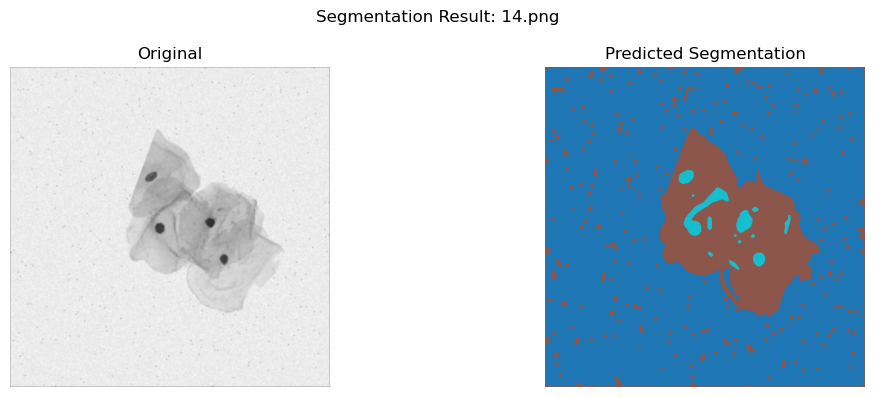

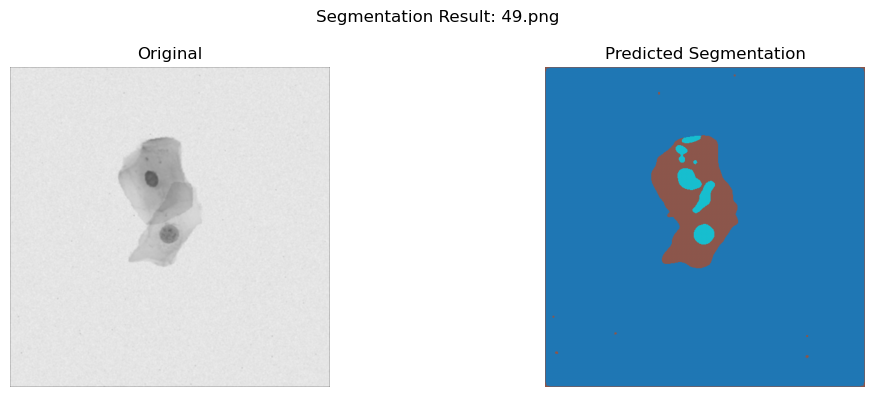

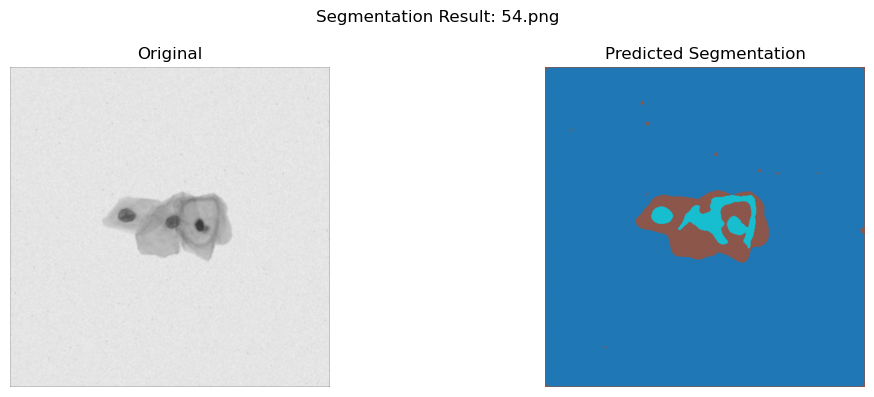

In [19]:
print('\nVisualizing segmentations...')
plot_segmentations(per_image_results, num_to_show=5)

In [21]:
# Custom faint-mid-dark color map with distinct hues
def get_custom_3color_map():
    return np.array([
        [219, 239, 255],   # Faint Blue (Background)
        [152, 226, 183],   # Mid Green (Cytoplasm)
        [139,   0,   0],   # Dark Red (Nucleus)
    ]) / 255.0

def visualize_segmentations_with_kmeans_gmm(test_items, per_image_results, kmeans, gmm, num_to_show=5):
    cmap = get_custom_3color_map()
    shown = 0
    for result in per_image_results:
        fname = result['fname']
        if fname not in test_items:
            continue
        entry = test_items[fname]
        feats = entry['feats']
        coords = entry['coords']
        H, W = entry['shape']

        # KMeans segmentation
        comps_km = kmeans.predict(feats)
        seg_km = np.zeros((H, W, K), dtype=int)
        for pidx, (y,x) in enumerate(coords):
            seg_km[y:y+PATCH_SIZE, x:x+PATCH_SIZE, comps_km[pidx]] += 1
        seg_km = np.argmax(seg_km, axis=2)

        # GMM segmentation
        n = feats.shape[0]
        log_resp = np.zeros((n, K))
        for j in range(K):
            log_resp[:, j] = np.log(gmm.weights_[j] + 1e-12) + log_mvnpdf_full(feats, gmm.means_[j], gmm.covariances_[j])
        max_lr = np.max(log_resp, axis=1, keepdims=True)
        rr = np.exp(log_resp - max_lr)
        resp = rr / (rr.sum(axis=1, keepdims=True) + 1e-12)
        comps_gmm = np.argmax(resp, axis=1)
        seg_gmm = np.zeros((H, W, K), dtype=int)
        for pidx, (y,x) in enumerate(coords):
            seg_gmm[y:y+PATCH_SIZE, x:x+PATCH_SIZE, comps_gmm[pidx]] += 1
        seg_gmm = np.argmax(seg_gmm, axis=2)

        # Original image
        img_path = os.path.join(TEST_DIR, fname)
        rgb = read_rgb(img_path)

        # Plot all
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(rgb)
        axs[0].set_title('Original')
        axs[0].axis('off')

        axs[1].imshow(cmap[seg_km])
        axs[1].set_title('KMeans Segmentation')
        axs[1].axis('off')

        axs[2].imshow(cmap[seg_gmm])
        axs[2].set_title('GMM Segmentation')
        axs[2].axis('off')

        plt.suptitle(f'Segmentation Comparison: {fname}')
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= num_to_show:
            break


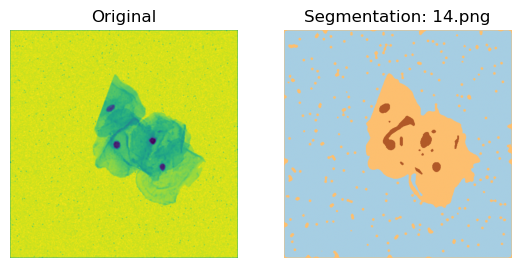

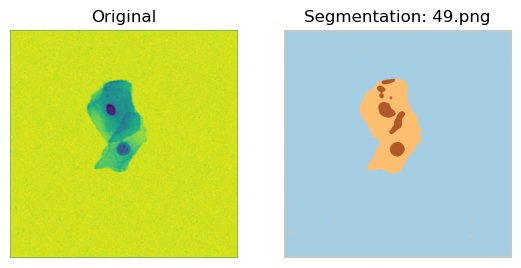

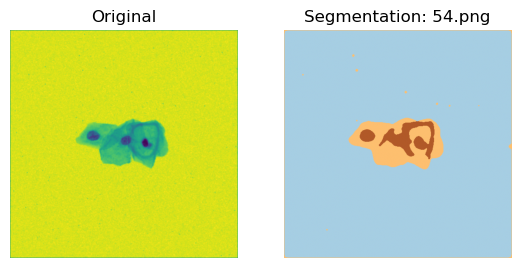

In [16]:
# show segmentation for each test image
for r in per_image_results:
    if 'seg' in r:
        seg = r['seg']
        fname = r['fname']
        img = mpimg.imread(os.path.join(TEST_DIR, fname))
        plt.figure(figsize=(10,5))
        plt.subplot(1,3,2); plt.imshow(img); plt.title('Original'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(seg, cmap='Paired'); plt.title(f'Segmentation: {fname}'); plt.axis('off')
        plt.show()
    else:
        # has true_flat/pred_flat; reconstruct seg for display
        shp = r['shape']
        seg = r['pred_flat'].reshape(shp)
        fname = r['fname']
        img = mpimg.imread(os.path.join(TEST_DIR, fname))
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1); plt.imshow(img); plt.title('Original'); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(seg, cmap='Paired'); plt.title(f'Segmentation: {fname}'); plt.axis('off')
        plt.show()


In [ ]:

print('Notebook ready. Save or run the cells to perform segmentation and (optionally) evaluation.') 
